In [1]:
from datasets import load_dataset
from myTokenize import SyllableTokenizer, WordTokenizer
import re

# 1) Load ALT parallel (Myanmar+English in 'translation')
ds = load_dataset("mutiyama/alt", "alt-parallel")  # ~20.1k rows

# 2) Tokenizers
mm_syll_tok = SyllableTokenizer()
mm_word_tok = WordTokenizer(engine="CRF")   # works for you ✅

USE_MM = "syllable"   # change to "word" if you want

def tokenize_mm(text: str):
    text = text.strip()
    if USE_MM == "syllable":
        return mm_syll_tok.tokenize(text)
    elif USE_MM == "word":
        return mm_word_tok.tokenize(text)
    else:
        raise ValueError("USE_MM must be 'syllable' or 'word'")

# Simple English tokenizer (baseline)
# (Later you can improve; for now keep it simple & explainable)
_en_punct = re.compile(r"([?.!,¿])")
def tokenize_en(text: str):
    text = text.strip().lower()
    text = _en_punct.sub(r" \1 ", text)
    text = re.sub(r"\s+", " ", text)
    return text.split()

# 3) Build tokenized pairs
pairs_tok = []
skipped = 0

for ex in ds["train"]:
    mm = ex["translation"].get("my", None)
    en = ex["translation"].get("en", None)
    if not mm or not en:
        skipped += 1
        continue
    mm_toks = tokenize_mm(mm)
    en_toks = tokenize_en(en)

    # skip weird empties
    if len(mm_toks) == 0 or len(en_toks) == 0:
        skipped += 1
        continue

    pairs_tok.append((mm_toks, en_toks))

print("USE_MM =", USE_MM)
print("Tokenized pairs:", len(pairs_tok))
print("Skipped:", skipped)
print("\nExample Myanmar tokens:", pairs_tok[0][0][:30])
print("Example English tokens:", pairs_tok[0][1][:30])
print("\nLengths (mm,en):", len(pairs_tok[0][0]), len(pairs_tok[0][1]))

/Users/thetsusann/Desktop/NLP/Assignments/Assignment3-Machine Translation/mt39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/thetsusann/Desktop/NLP/Assignments/Assignment3-Machine Translation/mt39/lib/python3.9/site-packages/google/api_core/_python_version_support.py:246: FutureWarning: You are using a non-supported Python version (3.9.6). Google will not post any further updates to google.api_core supporting this Python version. Please upgrade to the latest Python version, or at least Python 3.10, and then update google.api_core.
  warnings.warn(message, FutureWarning)
/Users/thetsusann/Desktop/NLP/Assignments/Assignment3-Machine Translation/mt39/lib/python3.9/site-packages/google/auth/__init__.py:54: FutureWarning: You are using a Python version 3.9 past its end of life. Google will update goo

USE_MM = syllable
Tokenized pairs: 18082
Skipped: 6

Example Myanmar tokens: ['ပြင်', 'သစ်', 'နိုင်', 'ငံ', 'ပါ', 'ရီ', 'မြို့', 'ပါ့', 'ဒက်စ်', 'ပ', 'ရင့်', 'စက်', '၌', '၂', '၀', '၀', '၇', 'ခု', 'နှစ်', 'ရပ်', 'ဘီ', 'ကမ္ဘာ့', 'ဖ', 'လား', 'တွင်', 'အီ', 'တ', 'လီ', 'သည်', 'ပေါ်']
Example English tokens: ['italy', 'have', 'defeated', 'portugal', '31-5', 'in', 'pool', 'c', 'of', 'the', '2007', 'rugby', 'world', 'cup', 'at', 'parc', 'des', 'princes', ',', 'paris', ',', 'france', '.']

Lengths (mm,en): 50 23


In [2]:
import random

random.seed(42)
random.shuffle(pairs_tok)

val_ratio = 0.10
n_val = int(len(pairs_tok) * val_ratio)

val_pairs = pairs_tok[:n_val]
train_pairs = pairs_tok[n_val:]

print("Train pairs:", len(train_pairs))
print("Val pairs:", len(val_pairs))

Train pairs: 16274
Val pairs: 1808


In [3]:
PAD = "<pad>"
SOS = "<sos>"
EOS = "<eos>"
UNK = "<unk>"
SPECIALS = [PAD, SOS, EOS, UNK]

In [4]:
from collections import Counter

def build_vocab(token_seqs, min_freq=2):
    """
    token_seqs: List[List[str]]
    returns: token2idx, idx2token
    """
    counter = Counter()
    for seq in token_seqs:
        counter.update(seq)

    vocab = SPECIALS.copy()
    for tok, freq in counter.items():
        if freq >= min_freq and tok not in vocab:
            vocab.append(tok)

    token2idx = {tok:i for i, tok in enumerate(vocab)}
    idx2token = {i:tok for tok,i in token2idx.items()}
    return token2idx, idx2token, counter

# Build from train only (standard practice)
mm_train_tokens = [mm for mm, en in train_pairs]
en_train_tokens = [en for mm, en in train_pairs]

mm2i, i2mm, mm_counter = build_vocab(mm_train_tokens, min_freq=2)
en2i, i2en, en_counter = build_vocab(en_train_tokens, min_freq=2)

print("Myanmar vocab size:", len(mm2i))
print("English vocab size:", len(en2i))
print("Myanmar PAD index:", mm2i[PAD], "English PAD index:", en2i[PAD])

Myanmar vocab size: 3143
English vocab size: 15393
Myanmar PAD index: 0 English PAD index: 0


In [5]:
def tokens_to_ids(tokens, token2idx):
    return [token2idx.get(t, token2idx[UNK]) for t in tokens]

def make_example(mm_tokens, en_tokens, mm2i, en2i, max_mm_len=80, max_en_len=80):
    # truncate (keep room for EOS/SOS)
    mm_tokens = mm_tokens[:max_mm_len-1]
    en_tokens = en_tokens[:max_en_len-1]

    src = tokens_to_ids(mm_tokens + [EOS], mm2i)

    dec_in  = tokens_to_ids([SOS] + en_tokens, en2i)
    dec_out = tokens_to_ids(en_tokens + [EOS], en2i)

    return src, dec_in, dec_out


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

class MTDataset(Dataset):
    def __init__(self, pairs, mm2i, en2i, max_mm_len=80, max_en_len=80):
        self.pairs = pairs
        self.mm2i = mm2i
        self.en2i = en2i
        self.max_mm_len = max_mm_len
        self.max_en_len = max_en_len

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        mm_tokens, en_tokens = self.pairs[idx]
        src, dec_in, dec_out = make_example(
            mm_tokens, en_tokens, self.mm2i, self.en2i,
            max_mm_len=self.max_mm_len, max_en_len=self.max_en_len
        )
        return torch.tensor(src), torch.tensor(dec_in), torch.tensor(dec_out)

def collate_mt(batch, pad_src, pad_tgt):
    """
    batch: list of (src, dec_in, dec_out) tensors (variable length)
    returns padded tensors + lengths
    """
    srcs, dec_ins, dec_outs = zip(*batch)

    src_lens = torch.tensor([len(x) for x in srcs], dtype=torch.long)
    tgt_lens = torch.tensor([len(x) for x in dec_ins], dtype=torch.long)

    max_src = max(src_lens).item()
    max_tgt = max(tgt_lens).item()

    src_pad = torch.full((len(batch), max_src), pad_src, dtype=torch.long)
    dec_in_pad  = torch.full((len(batch), max_tgt), pad_tgt, dtype=torch.long)
    dec_out_pad = torch.full((len(batch), max_tgt), pad_tgt, dtype=torch.long)

    for i, (s, di, do) in enumerate(zip(srcs, dec_ins, dec_outs)):
        src_pad[i, :len(s)] = s
        dec_in_pad[i, :len(di)] = di
        dec_out_pad[i, :len(do)] = do

    # masks (True where NOT pad)
    src_mask = (src_pad != pad_src)   # (bs, src_len)
    tgt_mask = (dec_in_pad != pad_tgt)

    return src_pad, src_lens, src_mask, dec_in_pad, dec_out_pad, tgt_lens, tgt_mask

train_ds = MTDataset(train_pairs, mm2i, en2i, max_mm_len=80, max_en_len=80)
val_ds   = MTDataset(val_pairs,   mm2i, en2i, max_mm_len=80, max_en_len=80)

pad_src = mm2i[PAD]
pad_tgt = en2i[PAD]

train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True,
    collate_fn=lambda b: collate_mt(b, pad_src, pad_tgt)
)
val_loader = DataLoader(
    val_ds, batch_size=64, shuffle=False,
    collate_fn=lambda b: collate_mt(b, pad_src, pad_tgt)
)

# sanity check one batch
batch = next(iter(train_loader))
src_pad, src_lens, src_mask, dec_in_pad, dec_out_pad, tgt_lens, tgt_mask = batch
print("src_pad:", src_pad.shape, "dec_in:", dec_in_pad.shape, "dec_out:", dec_out_pad.shape)
print("src_lens:", src_lens[:5].tolist(), "tgt_lens:", tgt_lens[:5].tolist())

src_pad: torch.Size([64, 80]) dec_in: torch.Size([64, 68]) dec_out: torch.Size([64, 68])
src_lens: [75, 50, 63, 54, 61] tgt_lens: [36, 22, 24, 22, 22]


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GeneralAttention(nn.Module):
    """
    e_i = s^T h_i  (dot / general when dims match)
    """
    def __init__(self):
        super().__init__()

    def forward(self, decoder_state, encoder_outputs, src_mask):
        """
        decoder_state: (bs, hid)
        encoder_outputs: (bs, src_len, hid)
        src_mask: (bs, src_len) True for real tokens
        returns:
          context: (bs, hid)
          attn_weights: (bs, src_len)
        """
        # (bs, src_len, 1) = bmm((bs, src_len, hid), (bs, hid, 1))
        scores = torch.bmm(encoder_outputs, decoder_state.unsqueeze(2)).squeeze(2)  # (bs, src_len)

        # mask pads
        scores = scores.masked_fill(~src_mask, -1e9)

        attn_weights = F.softmax(scores, dim=1)  # (bs, src_len)

        # context = sum_i alpha_i * h_i
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)  # (bs, hid)
        return context, attn_weights


class AdditiveAttention(nn.Module):
    """
    e_i = v^T tanh(W1 h_i + W2 s)
    """
    def __init__(self, hid_dim):
        super().__init__()
        self.W1 = nn.Linear(hid_dim, hid_dim, bias=False)
        self.W2 = nn.Linear(hid_dim, hid_dim, bias=False)
        self.v  = nn.Linear(hid_dim, 1, bias=False)

    def forward(self, decoder_state, encoder_outputs, src_mask):
        """
        decoder_state: (bs, hid)
        encoder_outputs: (bs, src_len, hid)
        """
        # expand decoder state over time
        # (bs, src_len, hid)
        dec = self.W2(decoder_state).unsqueeze(1)

        # (bs, src_len, hid)
        energy = torch.tanh(self.W1(encoder_outputs) + dec)

        # (bs, src_len)
        scores = self.v(energy).squeeze(2)

        scores = scores.masked_fill(~src_mask, -1e9)
        attn_weights = F.softmax(scores, dim=1)

        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        return context, attn_weights

In [8]:
class Encoder(nn.Module):
    def __init__(self, src_vocab_size, emb_dim, hid_dim, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(src_vocab_size, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(emb_dim, hid_dim, batch_first=True)

    def forward(self, src_ids, src_lens):
        """
        src_ids: (bs, src_len)
        src_lens: (bs,)
        returns:
          encoder_outputs: (bs, src_len, hid)
          (h, c): each (1, bs, hid)
        """
        emb = self.embedding(src_ids)

        packed = nn.utils.rnn.pack_padded_sequence(
            emb, src_lens.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_out, (h, c) = self.lstm(packed)
        encoder_outputs, _ = nn.utils.rnn.pad_packed_sequence(
            packed_out, batch_first=True
        )
        return encoder_outputs, (h, c)


class Decoder(nn.Module):
    def __init__(self, tgt_vocab_size, emb_dim, hid_dim, pad_idx, attention):
        super().__init__()
        self.embedding = nn.Embedding(tgt_vocab_size, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(emb_dim + hid_dim, hid_dim, batch_first=True)
        self.attention = attention
        self.fc_out = nn.Linear(hid_dim + hid_dim, tgt_vocab_size)

    def forward(self, input_token, hidden, cell, encoder_outputs, src_mask):
        """
        input_token: (bs,)  current decoder input ids
        hidden/cell: (1, bs, hid)
        """
        emb = self.embedding(input_token).unsqueeze(1)  # (bs, 1, emb)

        dec_state = hidden[-1]  # (bs, hid) "s" in equation

        context, attn_weights = self.attention(dec_state, encoder_outputs, src_mask)
        context = context.unsqueeze(1)  # (bs, 1, hid)

        lstm_in = torch.cat([emb, context], dim=2)  # (bs, 1, emb+hid)
        out, (hidden, cell) = self.lstm(lstm_in, (hidden, cell))  # out: (bs,1,hid)

        out = out.squeeze(1)          # (bs,hid)
        context = context.squeeze(1)  # (bs,hid)

        logits = self.fc_out(torch.cat([out, context], dim=1))  # (bs, vocab)
        return logits, hidden, cell, attn_weights

In [9]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, sos_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sos_idx = sos_idx
        self.device = device

    def forward(self, src_ids, src_lens, src_mask, dec_in_ids, teacher_forcing=True):
        """
        dec_in_ids: (bs, tgt_len)  (this is your dec_in_pad)
        returns:
          logits: (bs, tgt_len, vocab)
          attn_maps: (bs, tgt_len, src_len)
        """
        bs, tgt_len = dec_in_ids.shape
        encoder_outputs, (h, c) = self.encoder(src_ids, src_lens)

        vocab_size = self.decoder.fc_out.out_features
        logits = torch.zeros(bs, tgt_len, vocab_size, device=self.device)

        attn_maps = torch.zeros(bs, tgt_len, encoder_outputs.size(1), device=self.device)

        input_tok = dec_in_ids[:, 0]  # first token should be <sos>

        for t in range(1, tgt_len):
            step_logits, h, c, attn_w = self.decoder(input_tok, h, c, encoder_outputs, src_mask)
            logits[:, t] = step_logits
            attn_maps[:, t] = attn_w

            if teacher_forcing:
                input_tok = dec_in_ids[:, t]
            else:
                input_tok = step_logits.argmax(dim=1)

        return logits, attn_maps

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SRC_VOCAB = len(mm2i)
TGT_VOCAB = len(en2i)

emb_dim = 256
hid_dim = 256

# Choose ONE attention to start
attn = GeneralAttention()               # or AdditiveAttention(hid_dim)

enc = Encoder(SRC_VOCAB, emb_dim, hid_dim, pad_idx=mm2i["<pad>"])
dec = Decoder(TGT_VOCAB, emb_dim, hid_dim, pad_idx=en2i["<pad>"], attention=attn)

model = Seq2Seq(enc, dec, sos_idx=en2i["<sos>"], device=device).to(device)

batch = next(iter(train_loader))
src_pad, src_lens, src_mask, dec_in_pad, dec_out_pad, tgt_lens, tgt_mask = [x.to(device) for x in batch]

logits, attn_maps = model(src_pad, src_lens, src_mask, dec_in_pad, teacher_forcing=True)

print("logits:", logits.shape)
print("attn_maps:", attn_maps.shape)

logits: torch.Size([64, 52, 15393])
attn_maps: torch.Size([64, 52, 80])


In [11]:
PAD_IDX = en2i["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [12]:
import math
from tqdm import tqdm

def compute_loss(logits, targets, criterion):
    """
    logits: (bs, tgt_len, vocab)
    targets: (bs, tgt_len)
    """
    # skip t=0
    logits = logits[:, 1:, :]          # (bs, tgt_len-1, vocab)
    targets = targets[:, 1:]           # (bs, tgt_len-1)

    # flatten
    bs, tl, vocab = logits.shape
    logits = logits.reshape(bs*tl, vocab)
    targets = targets.reshape(bs*tl)

    return criterion(logits, targets)

def train_one_epoch(model, loader, optimizer, criterion, clip=1.0, device="cpu"):
    model.train()
    total_loss = 0.0

    for batch in tqdm(loader, leave=False):
        src_pad, src_lens, src_mask, dec_in_pad, dec_out_pad, tgt_lens, tgt_mask = [x.to(device) for x in batch]

        optimizer.zero_grad()
        logits, _ = model(src_pad, src_lens, src_mask, dec_in_pad, teacher_forcing=True)

        loss = compute_loss(logits, dec_out_pad, criterion)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    ppl = math.exp(avg_loss) if avg_loss < 50 else float("inf")
    return avg_loss, ppl

@torch.no_grad()
def evaluate(model, loader, criterion, device="cpu"):
    model.eval()
    total_loss = 0.0

    for batch in tqdm(loader, leave=False):
        src_pad, src_lens, src_mask, dec_in_pad, dec_out_pad, tgt_lens, tgt_mask = [x.to(device) for x in batch]

        logits, _ = model(src_pad, src_lens, src_mask, dec_in_pad, teacher_forcing=True)
        loss = compute_loss(logits, dec_out_pad, criterion)
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    ppl = math.exp(avg_loss) if avg_loss < 50 else float("inf")
    return avg_loss, ppl

In [13]:
import time

def run_experiment(attn_type="general", epochs=5, lr=1e-3, emb_dim=256, hid_dim=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if attn_type == "general":
        attn = GeneralAttention()
    elif attn_type == "additive":
        attn = AdditiveAttention(hid_dim)
    else:
        raise ValueError("attn_type must be 'general' or 'additive'")

    enc = Encoder(len(mm2i), emb_dim, hid_dim, pad_idx=mm2i["<pad>"])
    dec = Decoder(len(en2i), emb_dim, hid_dim, pad_idx=en2i["<pad>"], attention=attn)
    model = Seq2Seq(enc, dec, sos_idx=en2i["<sos>"], device=device).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=en2i["<pad>"])

    history = {"train_loss": [], "val_loss": [], "train_ppl": [], "val_ppl": []}

    for epoch in range(1, epochs+1):
        t0 = time.time()
        tr_loss, tr_ppl = train_one_epoch(model, train_loader, optimizer, criterion, device=device)
        va_loss, va_ppl = evaluate(model, val_loader, criterion, device=device)
        dt = time.time() - t0

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["train_ppl"].append(tr_ppl)
        history["val_ppl"].append(va_ppl)

        print(f"[{attn_type}] Epoch {epoch}/{epochs} | "
              f"train_loss={tr_loss:.4f} ppl={tr_ppl:.2f} | "
              f"val_loss={va_loss:.4f} ppl={va_ppl:.2f} | "
              f"time={dt:.1f}s")

    return model, history

In [14]:
general_model, general_hist = run_experiment("general", epochs=2, lr=1e-3)

[general] Epoch 1/2 | train_loss=6.6404 ppl=765.40 | val_loss=6.1591 ppl=473.00 | time=231.0s


[general] Epoch 2/2 | train_loss=6.1857 ppl=485.77 | val_loss=5.9829 ppl=396.59 | time=226.5s


In [15]:
add_model, add_hist = run_experiment("additive", epochs=2, lr=1e-3)

[additive] Epoch 1/2 | train_loss=6.6353 ppl=761.52 | val_loss=6.1239 ppl=456.66 | time=269.1s


[additive] Epoch 2/2 | train_loss=6.0970 ppl=444.52 | val_loss=5.8706 ppl=354.44 | time=270.2s


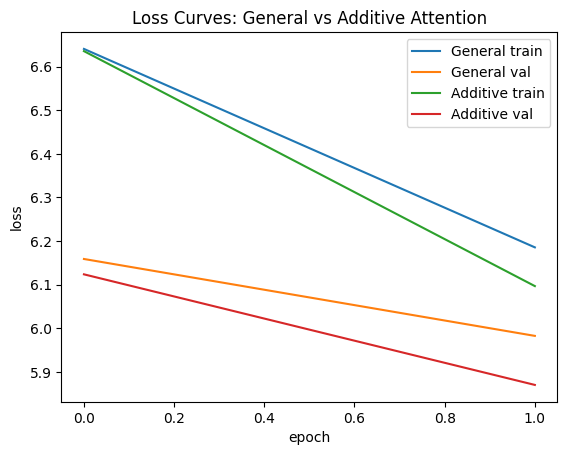

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(general_hist["train_loss"], label="General train")
plt.plot(general_hist["val_loss"], label="General val")
plt.plot(add_hist["train_loss"], label="Additive train")
plt.plot(add_hist["val_loss"], label="Additive val")
plt.title("Loss Curves: General vs Additive Attention")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [17]:
import pandas as pd

summary = pd.DataFrame([
    {
        "Attention": "General",
        "Train Loss": general_hist["train_loss"][-1],
        "Train PPL": general_hist["train_ppl"][-1],
        "Val Loss": general_hist["val_loss"][-1],
        "Val PPL": general_hist["val_ppl"][-1],
    },
    {
        "Attention": "Additive",
        "Train Loss": add_hist["train_loss"][-1],
        "Train PPL": add_hist["train_ppl"][-1],
        "Val Loss": add_hist["val_loss"][-1],
        "Val PPL": add_hist["val_ppl"][-1],
    }
])

summary

,Attention,Train Loss,Train PPL,Val Loss,Val PPL
0,General,6.185733,485.769101,5.982908,396.591977
1,Additive,6.096985,444.515657,5.870550,354.443955


In [18]:
def ids_to_tokens(ids, idx2tok, stop_at_eos=True, eos_idx=None):
    out = []
    for i in ids:
        tok = idx2tok[int(i)]
        if stop_at_eos and eos_idx is not None and int(i) == eos_idx:
            break
        out.append(tok)
    return out

In [19]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
add_model = add_model.to(device)
add_model.eval()

# take one sample from val_ds (tokenized+numericalized already)
src_ids, dec_in_ids, dec_out_ids = val_ds[0]
src_ids = src_ids.unsqueeze(0).to(device)          # (1, src_len)
dec_in_ids = dec_in_ids.unsqueeze(0).to(device)    # (1, tgt_len)

src_lens = torch.tensor([src_ids.size(1)], device=device)
src_mask = (src_ids != mm2i["<pad>"])

with torch.no_grad():
    logits, attn_maps = add_model(src_ids, src_lens, src_mask, dec_in_ids, teacher_forcing=True)

# get predicted tokens (teacher forcing logits, for display)
pred_ids = logits.argmax(dim=2).squeeze(0)     # (tgt_len,)
src_ids_1d = src_ids.squeeze(0)

In [20]:
# Source tokens
src_tokens = ids_to_tokens(src_ids_1d, i2mm, stop_at_eos=True, eos_idx=mm2i["<eos>"])

# Target tokens (we'll label using dec_out ground truth for clean visualization)
tgt_tokens = ids_to_tokens(dec_out_ids, i2en, stop_at_eos=True, eos_idx=en2i["<eos>"])

# attention: (1, tgt_len, src_len) -> trim to real lengths
A = attn_maps.squeeze(0)  # (tgt_len, src_len)

tgt_len = len(tgt_tokens)
src_len = len(src_tokens)

A_trim = A[1:tgt_len+1, :src_len].cpu()  # skip t=0, align lengths

/var/folders/qj/sypsr4hs17z923tv3v1dkt3w0000gn/T/ipykernel_17898/2322536825.py:11: UserWarning: Glyph 4161 (\N{MYANMAR DIGIT ONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qj/sypsr4hs17z923tv3v1dkt3w0000gn/T/ipykernel_17898/2322536825.py:11: UserWarning: Glyph 4169 (\N{MYANMAR DIGIT NINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qj/sypsr4hs17z923tv3v1dkt3w0000gn/T/ipykernel_17898/2322536825.py:11: UserWarning: Glyph 4166 (\N{MYANMAR DIGIT SIX}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qj/sypsr4hs17z923tv3v1dkt3w0000gn/T/ipykernel_17898/2322536825.py:11: UserWarning: Glyph 4165 (\N{MYANMAR DIGIT FIVE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qj/sypsr4hs17z923tv3v1dkt3w0000gn/T/ipykernel_17898/2322536825.py:11: UserWarning: Glyph 4097 (\N{MYANMAR LETTER KHA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qj/sypsr4hs17z923tv3v1dkt3w0000gn/T/ipykernel_17898/23

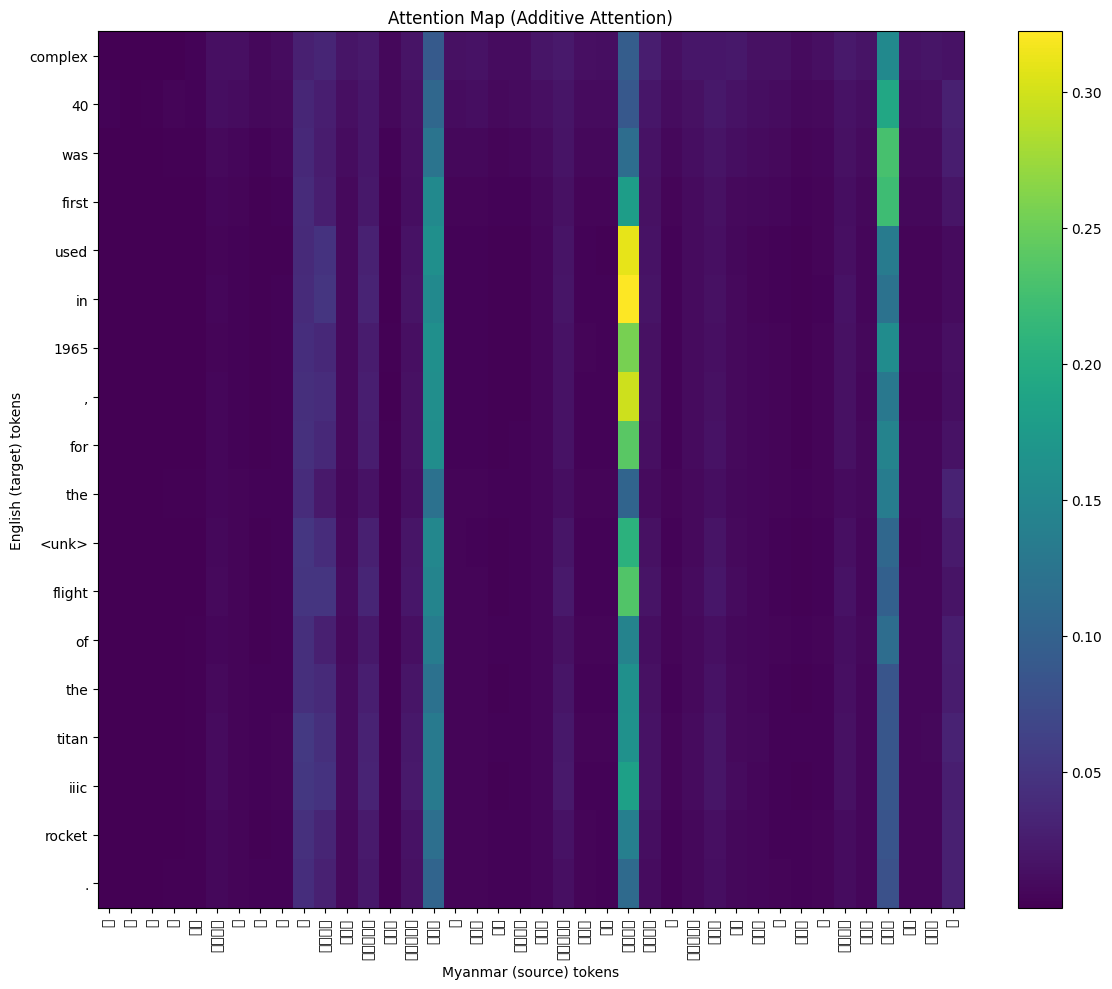

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(min(12, 0.35*src_len + 4), min(10, 0.35*tgt_len + 4)))
plt.imshow(A_trim, aspect="auto")
plt.yticks(range(tgt_len), tgt_tokens)
plt.xticks(range(src_len), src_tokens, rotation=90)
plt.xlabel("Myanmar (source) tokens")
plt.ylabel("English (target) tokens")
plt.title("Attention Map (Additive Attention)")
plt.colorbar()
plt.tight_layout()
plt.show()

In [22]:
@torch.no_grad()
def translate_mm_to_en(model, sentence_mm, max_len=60):
    model.eval()

    # tokenize
    mm_tokens = tokenize_mm(sentence_mm)
    src_ids = tokens_to_ids(mm_tokens + ["<eos>"], mm2i)

    src = torch.tensor(src_ids).unsqueeze(0).to(device)
    src_lens = torch.tensor([len(src_ids)], device=device)
    src_mask = (src != mm2i["<pad>"])

    encoder_outputs, (h, c) = model.encoder(src, src_lens)

    cur = torch.tensor([en2i["<sos>"]], device=device)
    out_tokens = []

    for _ in range(max_len):
        logits, h, c, _ = model.decoder(
            cur, h, c, encoder_outputs, src_mask
        )
        nxt = logits.argmax(dim=1).item()
        if nxt == en2i["<eos>"]:
            break
        out_tokens.append(i2en[nxt])
        cur = torch.tensor([nxt], device=device)

    return " ".join(out_tokens)


In [23]:
@torch.no_grad()
def translate_mm_to_en(model, sentence_mm, max_len=60):
    model.eval()

    # tokenize
    mm_tokens = tokenize_mm(sentence_mm)
    src_ids = tokens_to_ids(mm_tokens + ["<eos>"], mm2i)

    src = torch.tensor(src_ids).unsqueeze(0).to(device)
    src_lens = torch.tensor([len(src_ids)], device=device)
    src_mask = (src != mm2i["<pad>"])

    encoder_outputs, (h, c) = model.encoder(src, src_lens)

    cur = torch.tensor([en2i["<sos>"]], device=device)
    out_tokens = []

    for _ in range(max_len):
        logits, h, c, _ = model.decoder(
            cur, h, c, encoder_outputs, src_mask
        )
        nxt = logits.argmax(dim=1).item()
        if nxt == en2i["<eos>"]:
            break
        out_tokens.append(i2en[nxt])
        cur = torch.tensor([nxt], device=device)

    return " ".join(out_tokens)

In [27]:
print(translate_mm_to_en(add_model, "ပြင်သစ်သည် ဥရောပ၏ အကြီးဆုံး နိုင်ငံဖြစ်သည်။"))

is the of of . . .
